# 1. Prepare files

In [1]:
import click
import gzip
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)
%precision 2

import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [2]:
### Annotate with boostDM-CH prediction
Rules_matrix = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_simp_run20230803.tsv.gz', sep='\t')
Rules_matrix['ID2'] = Rules_matrix['chr'].astype(str)+'-'+Rules_matrix['pos'].astype(str)+'-'+ Rules_matrix['alt'].astype(str)
Rules_matrix

,gene,chr,pos,alt,Prot_pos,aachange,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO,ID2
0,ASXL1,20,32358779,C,2,K2Q,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0,20-32358779-C
1,ASXL1,20,32358779,G,2,K2E,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0,20-32358779-G
2,ASXL1,20,32358779,T,2,K2*,0,1,0,0,0.989503,1,0.0,0.0,0.0,0.0,20-32358779-T
3,ASXL1,20,32358780,C,2,K2T,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0,20-32358780-C
4,ASXL1,20,32358780,G,2,K2R,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0,20-32358780-G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,21,43107490,C,2,A2G,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0,21-43107490-C
87935,U2AF1,21,43107490,T,2,A2E,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0,21-43107490-T
87936,U2AF1,21,43107491,A,2,A2S,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0,21-43107491-A
87937,U2AF1,21,43107491,G,2,A2P,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0,21-43107491-G


In [3]:
### Read data ch mutations and age (NOT PROVIDED)
# Created in section 1_Post_processing_calling
patient_age_ch = pd.read_csv('../1_Post_processing_calling/patient_450k_age_670124_ALL_MUTATIONS_20230802_v3.txt.gz',sep="\t")
print(f'Patients:{len(patient_age_ch)}')
print(f'Columns:{list(patient_age_ch.columns)}')

### Upload general cancer information per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")
ukb200K_ch_cancer = pd.merge(patient_age_ch, patient_cancer,  how='inner', on='patient')
# Upload Cancer variables per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb200k_Siddharta_670124_simple.txt.gz', sep="\t")
patient_cancer = patient_cancer.rename(columns={'eid': 'patient'})
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)
# Create a unique variable for hematological cancer
yeears = ['var_MM_years', 'var_MPN_years', 'var_MDS_years', 'var_CMML_years',
          'var_AML_years', 'var_LL_years', 'var_Lymphoma_years', 'var_Myeloma_years']
ukb200K_ch_cancer['var_HNALL_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_HNALL_var'] = np.where(ukb200K_ch_cancer['var_HNALL_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_HNALL_post'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_HNALL_pre'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] < 0, 1, 0)
len(ukb200K_ch_cancer)

Patients:469880
Columns:['patient', 'age_recruitment', 'age_group', 'CH_driver', 'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers', 'num_CH_drivers', 'CH_driver_multiple', 'num_CH_potential', 'ASXL1_driver', 'ASXL1_passenger', 'ASXL1_potential', 'CHEK2_driver', 'CHEK2_passenger', 'CHEK2_potential', 'DNMT3A_driver', 'DNMT3A_passenger', 'DNMT3A_potential', 'GNAS_driver', 'GNAS_passenger', 'GNAS_potential', 'IDH2_driver', 'IDH2_passenger', 'IDH2_potential', 'MDM4_driver', 'MDM4_passenger', 'MDM4_potential', 'PPM1D_driver', 'PPM1D_passenger', 'PPM1D_potential', 'SF3B1_driver', 'SF3B1_passenger', 'SF3B1_potential', 'SRSF2_driver', 'SRSF2_passenger', 'SRSF2_potential', 'TET2_driver', 'TET2_passenger', 'TET2_potential', 'TP53_driver', 'TP53_passenger', 'TP53_potential', 'U2AF1_driver', 'U2AF1_passenger', 'U2AF1_potential', 'chromatin_gene_driver', 'DDR_gene_driver', 'splicing_gene_driver', 'chromatin_gene_passenger', 'DDR_gene_passenger', 'splicing_gene_passenger', 'chromati

/tmp/jobs/jramis/9874679/ipykernel_54034/2789846261.py:9: DtypeWarning: Columns (36,37,38,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")


469880

In [4]:
### Upload UKB mutations (NOT PROVIDED)
# Created in section 1_Post_processing_calling
boostDM_predictions = pd.read_csv('../1_Post_processing_calling/All450k_filtered_boostDM_ALL_age_20230802_v3.vcf', sep="\t", compression='gzip')
boostDM_predictions = boostDM_predictions.rename(columns={'case': 'patient', 'BoostDM':'Drivers_12genes'})
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Prot_pos'].isna()]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Consequence'].isin(['start_lost', 'stop_lost', 'stop_retained_variant'])]
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(patient_age_ch['patient'])]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['ALT'].str.contains(',')]
# boostDM_predictions['patient'] = boostDM_predictions['patient'].astype(str)
len(boostDM_predictions)

203351

In [5]:
#Select mutations based on driver call
BoostDM_dirvers = Rules_matrix[Rules_matrix['boostDM_class']==1]
Niroula_dirvers = Rules_matrix[Rules_matrix['Niroula']==1]
Bick_dirvers = Rules_matrix[Rules_matrix['Bick']==1]
WHO_dirvers = Rules_matrix[Rules_matrix['WHO']==1]

boostDM_predictions['BoostDM'] = np.where(boostDM_predictions['ID2'].isin(BoostDM_dirvers['ID2'].to_list()), 1, 0)
print('BoostDM_Done')
boostDM_predictions['Niroula'] = np.where(boostDM_predictions['ID2'].isin(Niroula_dirvers['ID2'].to_list()), 1, 0)
print('Niroula_Done')
boostDM_predictions['Bick'] = np.where(boostDM_predictions['ID2'].isin(Bick_dirvers['ID2'].to_list()), 1, 0)
print('Bick_Done')
boostDM_predictions['WHO'] = np.where(boostDM_predictions['ID2'].isin(WHO_dirvers['ID2'].to_list()), 1, 0)
print('WHO_Done')

BoostDM_Done
Niroula_Done
Bick_Done
WHO_Done


In [6]:
ukb200K_ch_cancer_nonHN = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
len(ukb200K_ch_cancer_nonHN)

467202

In [7]:
patients_CHdrivers_Bick = boostDM_predictions[boostDM_predictions['Bick'] == 1]['patient'].to_list()
print(len(patients_CHdrivers_Bick))
ukb200K_ch_cancer_nonHN['Bick_CH_driver'] = np.where(ukb200K_ch_cancer_nonHN['patient'].isin(patients_CHdrivers_Bick), 1, 0)
ukb200K_ch_cancer_nonHN['Bick_CH_driver'].value_counts()

patients_CHdrivers_Niroula = boostDM_predictions[boostDM_predictions['Niroula'] == 1]['patient'].to_list()
print(len(patients_CHdrivers_Niroula))
ukb200K_ch_cancer_nonHN['Niroula_CH_driver'] = np.where(ukb200K_ch_cancer_nonHN['patient'].isin(patients_CHdrivers_Bick), 1, 0)
ukb200K_ch_cancer_nonHN['Niroula_CH_driver'].value_counts()

patients_CHdrivers_WHO = boostDM_predictions[boostDM_predictions['WHO'] == 1]['patient'].to_list()
print(len(patients_CHdrivers_WHO))
ukb200K_ch_cancer_nonHN['WHO_CH_driver'] = np.where(ukb200K_ch_cancer_nonHN['patient'].isin(patients_CHdrivers_Bick), 1, 0)
ukb200K_ch_cancer_nonHN['WHO_CH_driver'].value_counts()

37426
60021
56063


0    432796
1     34406
Name: WHO_CH_driver, dtype: int64

# 2. UKB mutations by different CH definitions

In [8]:
def get_PFAMs_per_transcript(PFAM_files, PFAM_info, transcript):
    df_pfam = pd.read_csv(PFAM_files, sep="\t", names=["ENSEMBL_GENE", "ENSEMBL_TRANSCRIPT", "START", "END", "DOMAIN"])
    df_names = pd.read_csv(PFAM_info, sep="\t", names=["DOMAIN", "CLAN", "CLAN_NAME", "DOMAIN_NAME", "Long Name"])

    # Get domains
    df_pfam_gene = df_pfam[(df_pfam["ENSEMBL_TRANSCRIPT"] == transcript)]
    df_pfam_gene = df_pfam_gene[["ENSEMBL_TRANSCRIPT", "START", "END", "DOMAIN"]].drop_duplicates()
    df_pfam_gene = pd.merge(df_pfam_gene, df_names[["DOMAIN", "DOMAIN_NAME"]].drop_duplicates(), how="left")
    df_pfam_gene["POS"] = df_pfam_gene.apply(lambda row: row["START"] + ((row["END"] - row["START"]) // 2), axis=1)
    df_pfam_gene["SIZE"] = df_pfam_gene.apply(lambda row: row["END"] - row["START"] + 1, axis=1)
    df_pfam_gene["Color"] = "#998ec3"

    return df_pfam_gene

def get_transctipt(gene):
    return boostDM_predictions[boostDM_predictions['SYMBOL']==gene]['ENST'].unique()[0]

In [9]:
def plot_gene_full_nucleotide_simple(subset_data_pfam, df, transcript, path_coord,
                              ax0, all_possible=False):

    # remove those mutations not falling in CDS:
    df = df[df['AA'] != 'n']

    # Configure the axis
    ax0.set_title('Observed mutations in CH (n='+str(df["number_observed_muts"].sum())+')', size=8)
    ax0.set_ylabel("mutation count", size=8)

    ax0.spines['bottom'].set_visible(1)
    ax0.spines['left'].set_linewidth(1)
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_linewidth(False)
    ax0.tick_params(axis='y', labelsize=6, pad=0.25, width=0.25, length=1.5)
    ax0.tick_params(axis='x', labelsize=0)
#     ax1.tick_params(axis='x', length=0)
#     ax1.set_yticks([])

    # set equivalent coordinates for the three possible mutations
    set_coordinates = get_positions_in_CDS(transcript, path_coord)


    # we need to get the set of equivalent coordinates per gene
    equivalent_coordinates = {coord: i for i, coord in enumerate(set_coordinates)}
    vals_coord = list(equivalent_coordinates.values())
    axs = [ax0]
    for ax in axs:
        ax.set_xlim(np.min(vals_coord), np.max(vals_coord))

    # plot observed mutations
    pos_list = df["POS"].tolist()
    ys = df["number_observed_muts"].values

    d = df["Drivers_12genes"].values

    coordinates_mutations = []

    passenger_x = []
    passenger_y = []
    passenger_color = []

    driver_x = []
    driver_y = []
    driver_color = []

    # for each of the positions
    for i, p in enumerate(pos_list):
        if ys[i] > 0:

            coordinates_mutations.append([(equivalent_coordinates[p], 0),
                                          (equivalent_coordinates[p], ys[i] - 0.1)])

            if d[i] == 0:

                passenger_x.append(equivalent_coordinates[p])
                if all_possible:
                    passenger_y.append(d[i])
                else:
                    passenger_y.append(ys[i])
                passenger_color.append('#636363')

            else:
                driver_x.append(equivalent_coordinates[p])
                if all_possible:
                    driver_y.append(d[i])
                else:
                    driver_y.append(ys[i])
                driver_color.append('#ac0f0f')

    lc = mc.LineCollection(coordinates_mutations, colors='black', linewidths=1, alpha=0.3)
    ax0.add_collection(lc)

    size = 10
    ax0.scatter(passenger_x, passenger_y, s=size, c=passenger_color, alpha=0.7, label='non-driver')
    ax0.scatter(driver_x, driver_y, s=size, c=driver_color, alpha=0.7, label='driver')
    ax0.set_xticks([])
#     ax0.set_xticks(np.append(np.arange(0, max(matrix_gene['Prot_pos']), 200)[:-1], max(matrix_gene['Prot_pos'])))
#     ax0.set_xticklabels(np.append(np.arange(0, max(matrix_gene['Prot_pos']), 200)[:-1], max(matrix_gene['Prot_pos'])), fontsize = 8)
    leg = ax0.legend(prop={'size': 6})
    leg.get_frame().set_linewidth(0.0)
    
def get_positions_in_CDS(transcript, path_coord):
    df = pd.read_csv(path_coord, sep='\t', low_memory=False,
                     names=['gene', 'gene_symbol', 'prot', 'chr', 's', 'e', 'aa', 'cds', 'genpos',
                            'strand', 'transcript'])

    toappend = []
    strand = ''
    for i, row in df[df['transcript'] == transcript].sort_values(by='s').iterrows():
        toappend.extend([i for i in range(row['s'], row['e'] + 1)])
        strand = row['strand']
    if strand == -1:
        toappend = toappend[::-1]

    return toappend

def plot_barplot_drivers(count_driver_unique, count_total_unique, ax):

    nondriver_frac = (count_total_unique - count_driver_unique) / count_total_unique
    driver_frac = count_driver_unique / count_total_unique
    ax.barh(0, nondriver_frac, height=0.3, color='grey', left=0, alpha=0.5)
    ax.barh(0, driver_frac, height=0.3, left=nondriver_frac, color='darkred', alpha=0.5)
    # Divide per 3 to be more centric and 0f to avoid scientific notation
    ax.text(nondriver_frac / 3, 0, f'{count_total_unique - count_driver_unique:,.0f}', size=5)
    ax.text(nondriver_frac + (driver_frac/6), 0, f'{count_driver_unique:,.0f}', color='white', size=5)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 1)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(str(round(driver_frac*100, 2))+'% unique\ndrivers', rotation=0, labelpad=24, size=5)

# Changed
def plot_barplot_drivers_nonunique(count_driver, count_total, ax):

    nonpredicted_frac = (count_total - count_driver) / count_total
    predicted_frac = count_driver / count_total
    ax.barh(0, nonpredicted_frac, height=0.3, color='grey', left=0)
    ax.barh(0, predicted_frac, height=0.3, left=nonpredicted_frac, color='darkred')
    # Divide per 3 to be more centric and 0f to avoid scientific notation
    ax.text(nonpredicted_frac / 3, 0, f'{count_total - count_driver:,.0f}', size=5)
    ax.text(nonpredicted_frac + (predicted_frac / 6), 0, f'{count_driver:,.0f}', color='white', size=5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(0, 1)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(str(round(predicted_frac*100, 2))+'% drivers', rotation=0, labelpad=24, size=5)

/tmp/jobs/jramis/9874679/ipykernel_54034/1691806285.py:119: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "|k" (-> color='k'). The keyword argument will take precedence.
  ax0.plot(GENE[GENE['Niroula']==1]['Prot_pos'], np.full_like(GENE[GENE['Niroula']==1]['Prot_pos'], 4), '|k', markeredgewidth=0.1,  markersize=5, color='#82678E')
/tmp/jobs/jramis/9874679/ipykernel_54034/1691806285.py:120: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "|k" (-> color='k'). The keyword argument will take precedence.
  ax0.plot(GENE[GENE['Bick']==1]['Prot_pos'], np.full_like(GENE[GENE['Bick']==1]['Prot_pos'], 2), '|k', markeredgewidth=0.1,  markersize=5, color='#6DAC67')
/tmp/jobs/jramis/9874679/ipykernel_54034/1691806285.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "|k" (-> color='k'). The keyword argument will take precedence.
  ax0.plot(GENE[GENE['WHO']==

/tmp/jobs/jramis/9874679/ipykernel_54034/1691806285.py:119: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "|k" (-> color='k'). The keyword argument will take precedence.
  ax0.plot(GENE[GENE['Niroula']==1]['Prot_pos'], np.full_like(GENE[GENE['Niroula']==1]['Prot_pos'], 4), '|k', markeredgewidth=0.1,  markersize=5, color='#82678E')
/tmp/jobs/jramis/9874679/ipykernel_54034/1691806285.py:120: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "|k" (-> color='k'). The keyword argument will take precedence.
  ax0.plot(GENE[GENE['Bick']==1]['Prot_pos'], np.full_like(GENE[GENE['Bick']==1]['Prot_pos'], 2), '|k', markeredgewidth=0.1,  markersize=5, color='#6DAC67')
/tmp/jobs/jramis/9874679/ipykernel_54034/1691806285.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "|k" (-> color='k'). The keyword argument will take precedence.
  ax0.plot(GENE[GENE['WHO']==

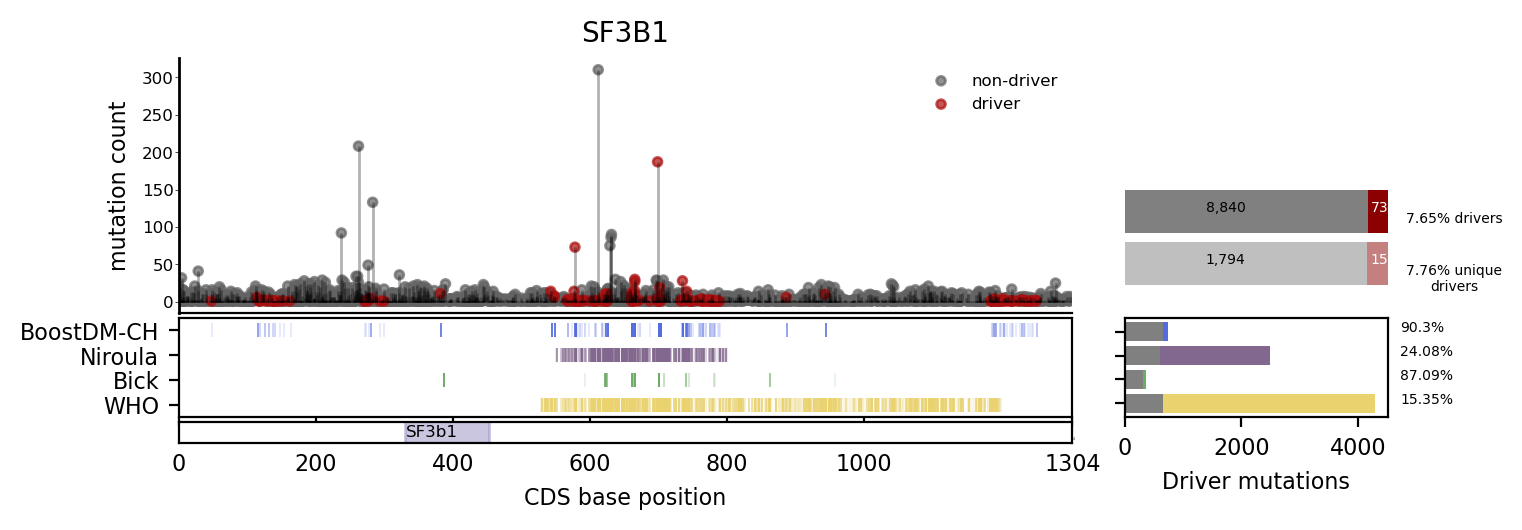

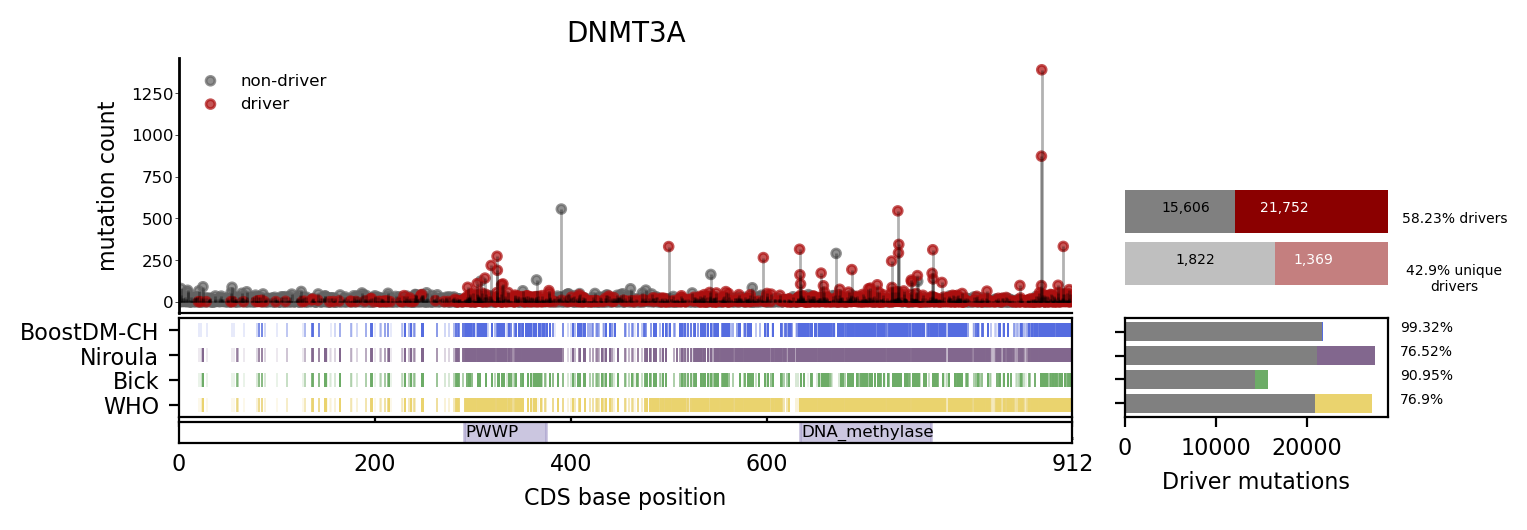

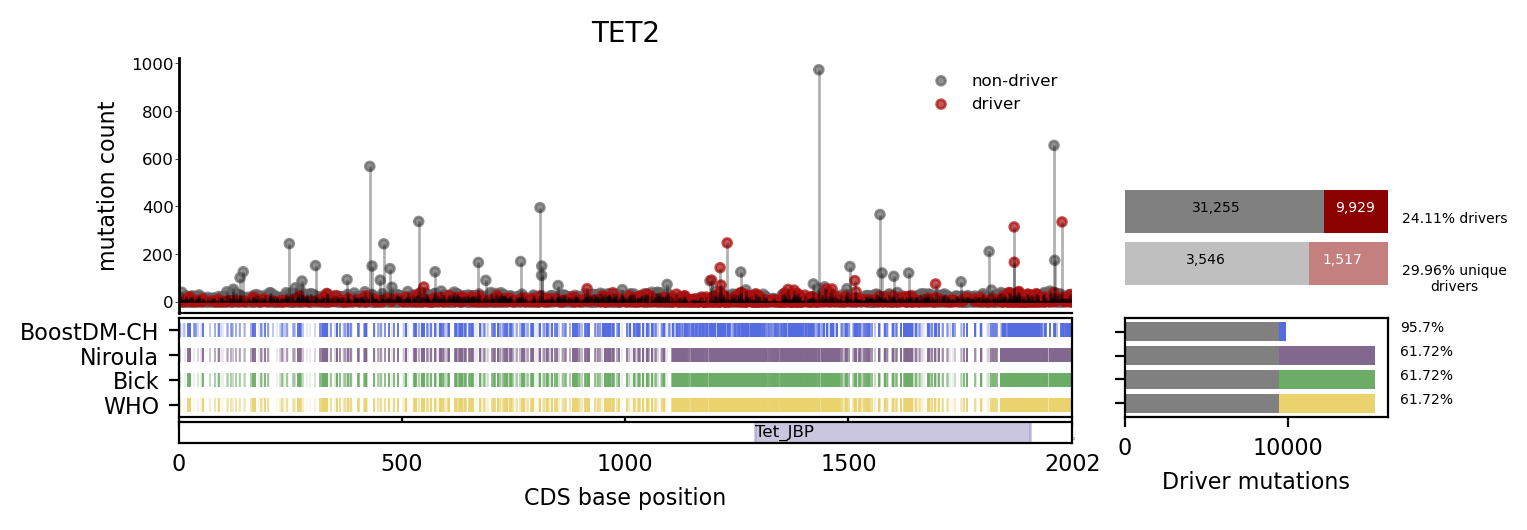

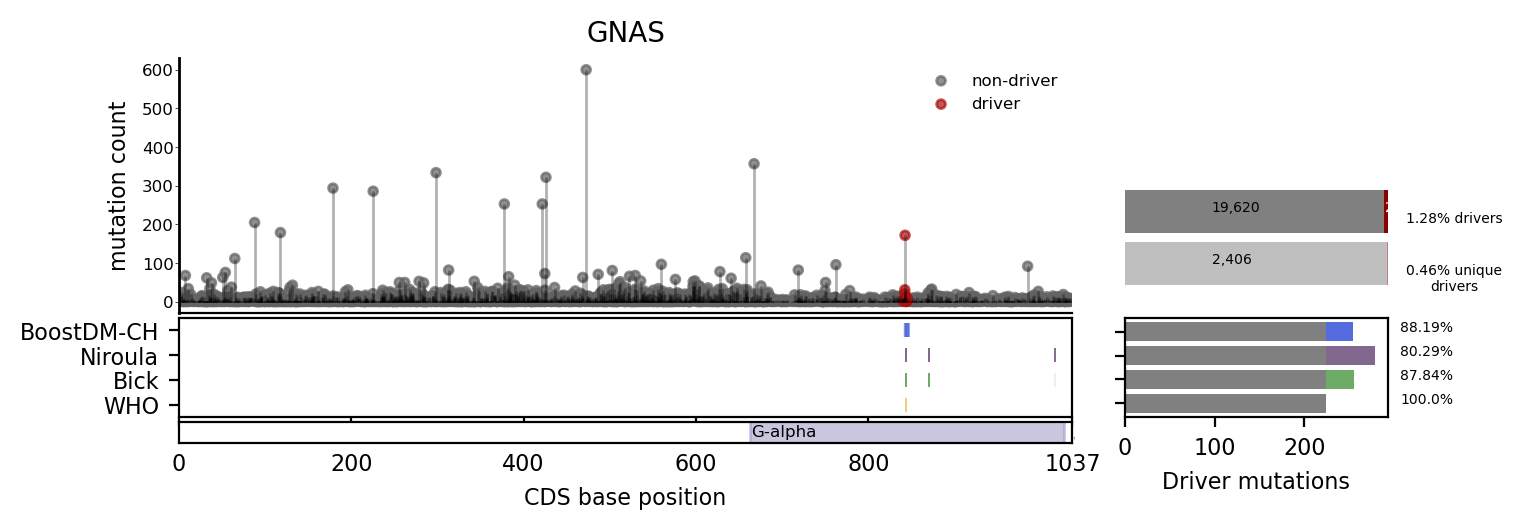

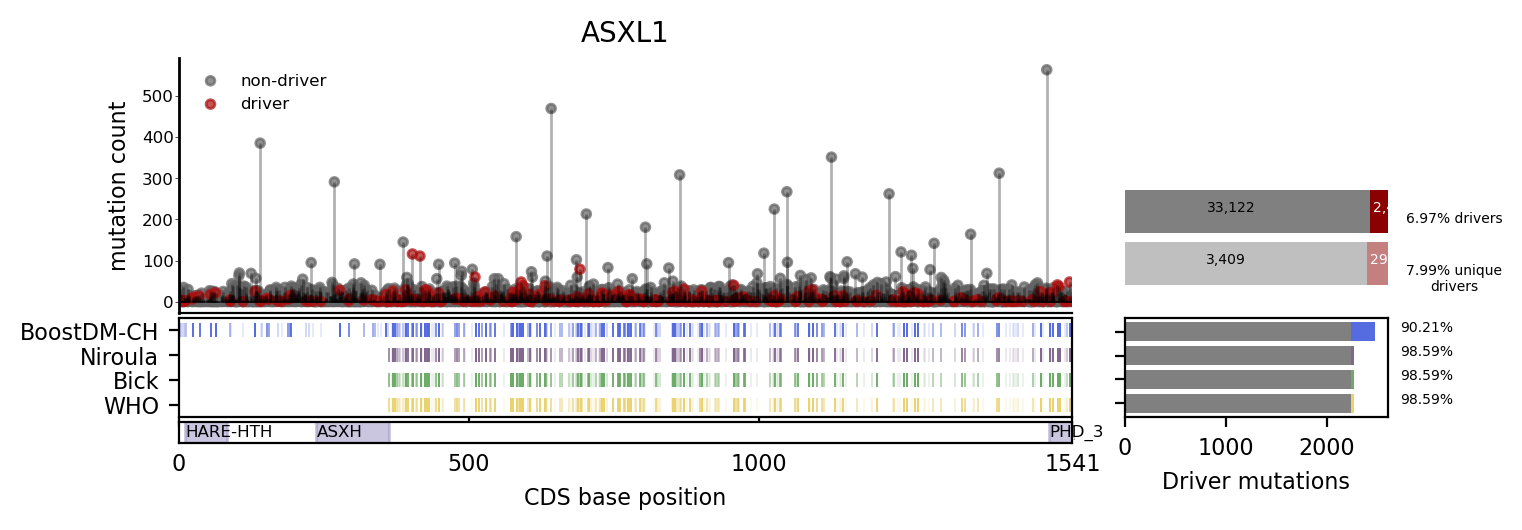

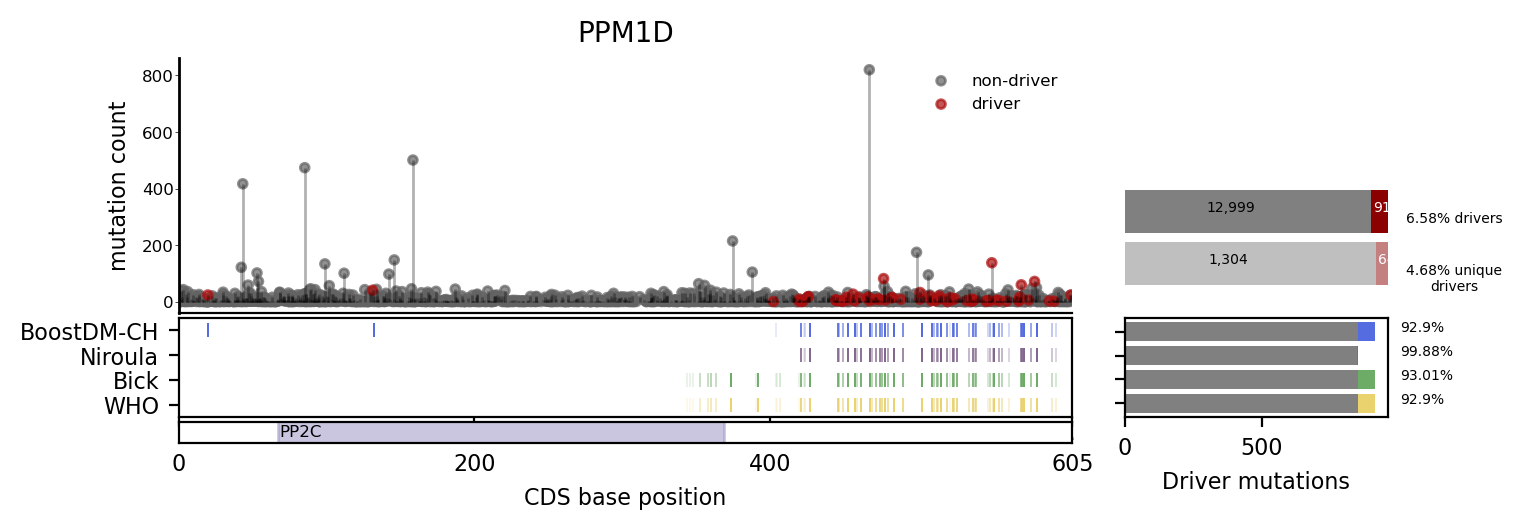

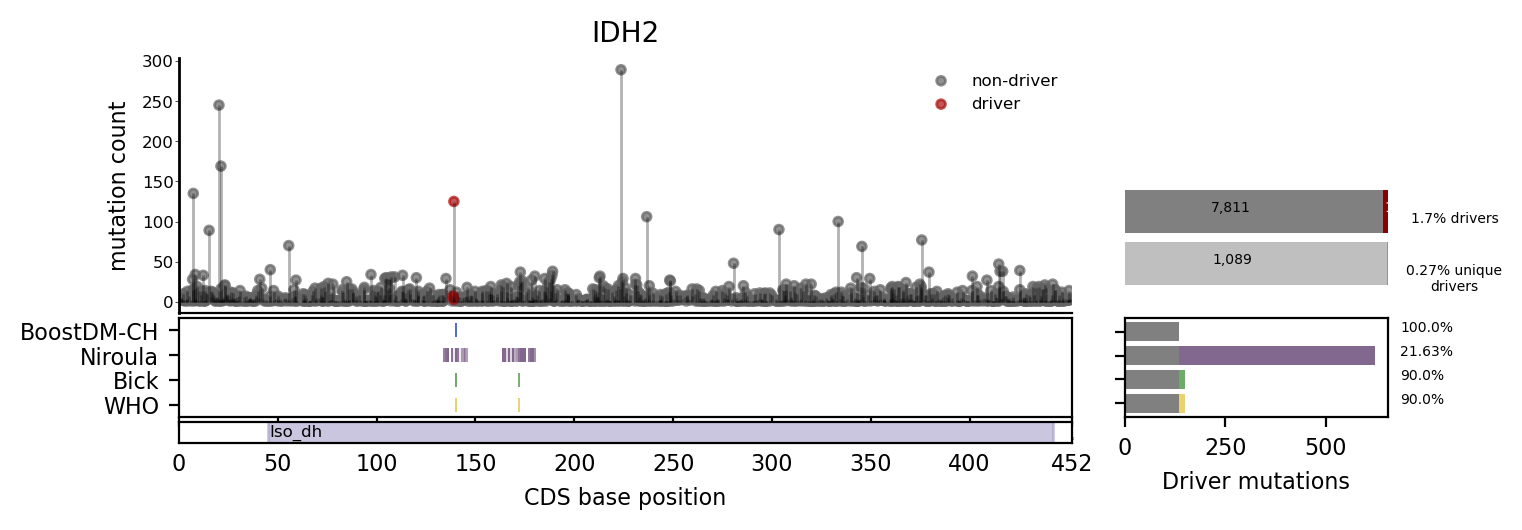

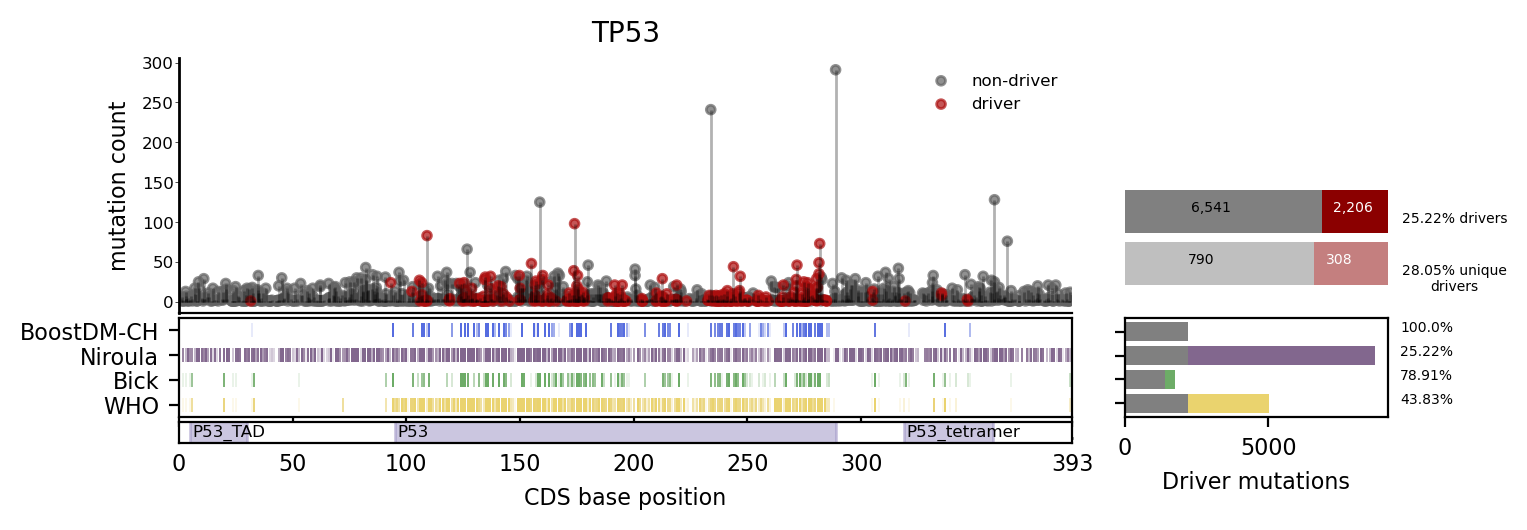

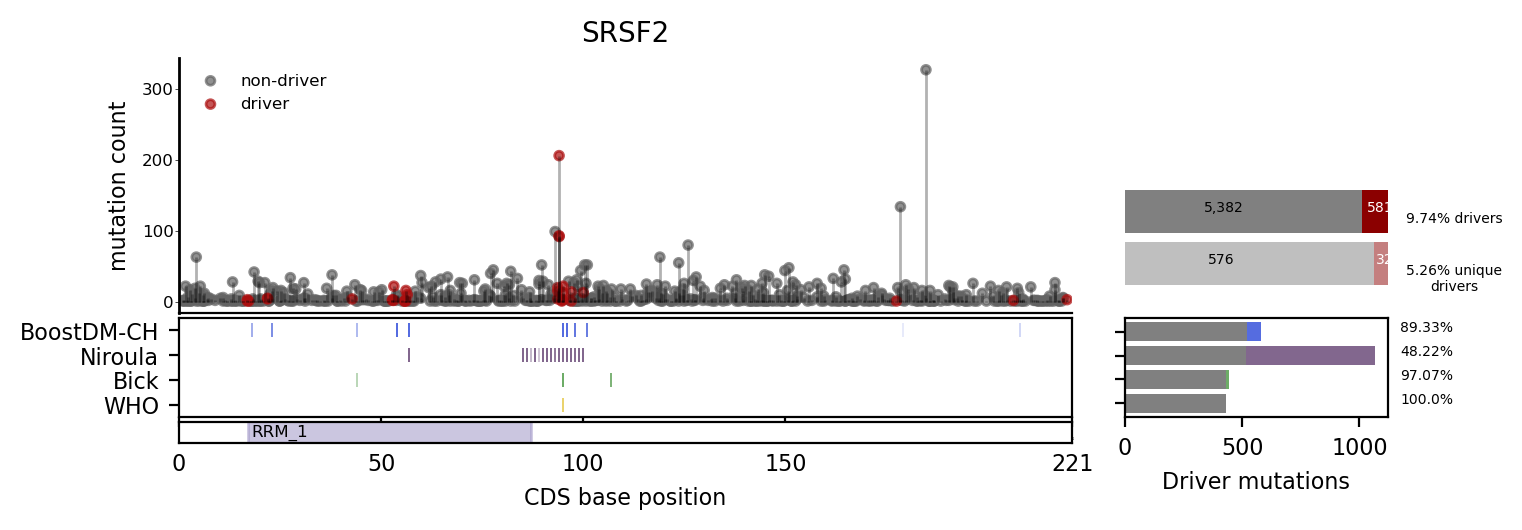

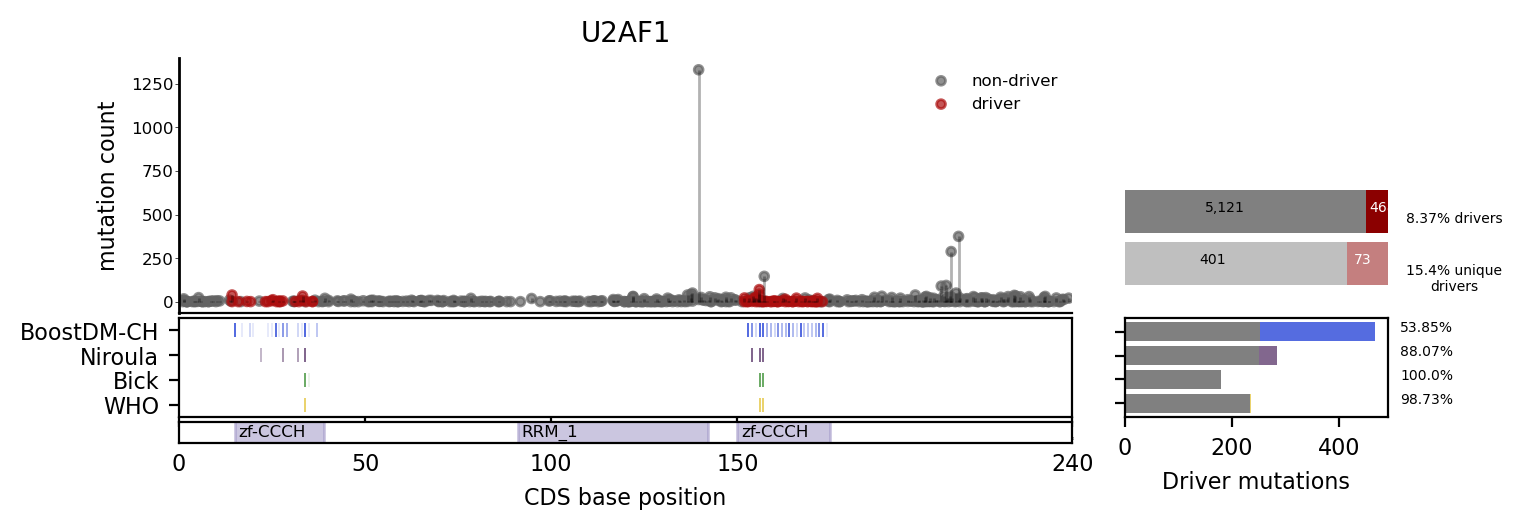

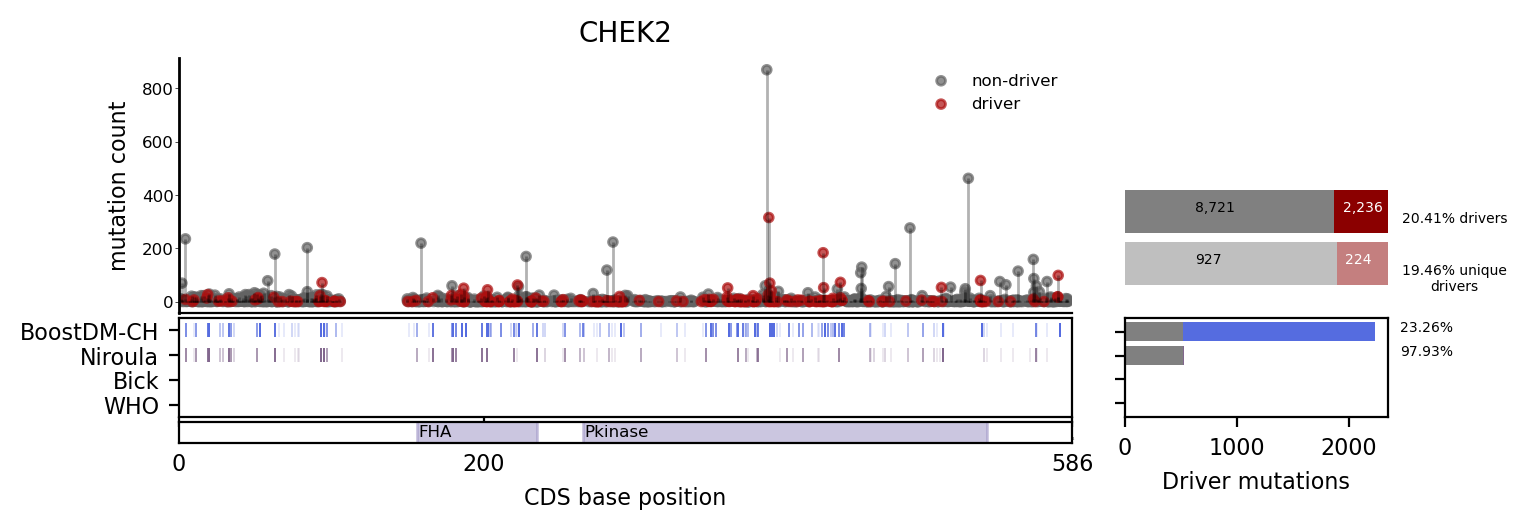

In [10]:
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections as mc

for gene in ['SF3B1', 'DNMT3A', 'TET2', 'GNAS', 'ASXL1', 'PPM1D', 'IDH2', 'TP53', 'SRSF2', 'U2AF1', 'CHEK2']:
# for gene in ['DNMT3A']:

    fig = plt.figure(figsize=(7.8, 2.5), dpi=200)
    gs = gridspec.GridSpec(15, 4, figure=fig)

    # Method comparison
    ax0 = plt.subplot(gs[-5:-1, :3])
    #protein body
    ax1 = plt.subplot(gs[-1, :3], sharex=ax0)
    #Method overlapping
    ax2 = plt.subplot(gs[-5:-1, 3])
    # needleplot
    ax_0 = plt.subplot(gs[:-5, :3])
    ax_1 = plt.subplot(gs[-10:-8, 3])
    ax_2 = plt.subplot(gs[-8:-6, 3])

    #############
    # Prepare data
    ##############
    matrix_gene = Rules_matrix[(Rules_matrix['gene']==gene)]
    GENE = boostDM_predictions[(boostDM_predictions['SYMBOL']==gene)]
    GENE["AA"] = GENE.apply(lambda row: row["AA_change"][0], axis=1)
    GENE['ID'] = GENE.apply(lambda x: '{}_{}'.format(x['POS'], x['ALT']), axis=1)
    score_values = GENE['Drivers_12genes'].tolist()
    count_driver_unique = len(set(GENE[GENE['Drivers_12genes']==1]['ID']))  # predicted to be drivers (unique)
    count_driver = len(GENE[GENE['Drivers_12genes']==1]['ID'])  # predicted to be drivers
    count_total = len(GENE['ID'])  # total number of mutations
    count_total_unique = len(set(GENE['ID']))  # total mutations (unique)
    data = GENE.groupby(["ID", "POS", "AA", "Prot_pos", "SYMBOL", "ENST", "Drivers_12genes"], as_index=False).agg({"patient": "count"})
    data.rename(columns={"patient": "number_observed_muts"}, inplace=True)

    # get PFAM domains and subset the mutation data
    PFAM_files = '../../../Paper_data/pfam/pfam_biomart.tsv.gz'
    PFAM_info = '../../../Paper_data/pfam/pfam_names.info.csv'
    path_coord = '../../../Paper_data/pfam/cds_biomart.tsv'
    subset_data_pfam = get_PFAMs_per_transcript(PFAM_files, PFAM_info, get_transctipt(gene))
    
    ######
    #needle plot
    ######
    plot_barplot_drivers(count_driver_unique, count_total_unique, ax_2)
    plot_barplot_drivers_nonunique(count_driver, count_total, ax_1)
    plot_gene_full_nucleotide_simple(subset_data_pfam, data, get_transctipt(gene), path_coord, ax_0)

    ######
    #BARPLOT
    ######
    BoostDM = len(GENE[(GENE['Drivers_12genes']==1)]['ID2'].to_list())
    Niroula = len(GENE[(GENE['Niroula']==1)]['ID2'].to_list())
    Overlapping_Niroula = len(GENE[(GENE['Drivers_12genes']==1) & (GENE['Niroula']==1)]['ID2'].to_list())
    Bick = len(GENE[(GENE['Bick']==1)]['ID2'].to_list())
    Overlapping_Bick = len(GENE[(GENE['Drivers_12genes']==1) & (GENE['Bick']==1)]['ID2'].to_list())
    WHO = len(GENE[(GENE['WHO']==1)]['ID2'].to_list())
    Overlapping_WHO = len(GENE[(GENE['Drivers_12genes']==1) & (GENE['WHO']==1)]['ID2'].to_list())
    allposition = set(GENE[(GENE['Niroula']==1)]['ID2'].to_list()+GENE[(GENE['Bick']==1)]['ID2'].to_list()+GENE[(GENE['WHO']==1)]['ID2'].to_list())
    Overlaping_all=len(GENE[(GENE['Drivers_12genes']==1) & (GENE['ID2'].isin(list(set(allposition))))])

    # create data
    x = ['WHO', 'Bick', 'Niroula', 'BoostDM']
    y1 = [Overlapping_WHO, Overlapping_Bick, Overlapping_Niroula, Overlaping_all]
    y2 = [0, 0, 0, BoostDM-Overlaping_all]
    y3 = [0, 0, Niroula-Overlapping_Niroula, 0]
    y4 = [0, Bick-Overlapping_Bick, 0, 0]
    y5 = [WHO-Overlapping_WHO, 0, 0, 0]
    h = 0.6
    size_param = 8

    # plot bars in stack manner
    #     plt.figure(figsize=(4, 2))
    max_len = max([BoostDM,Niroula,Bick,WHO])
    ax2.barh(x, y1, color='grey')
    ax2.barh(x, y2, left=y1, color='#556CE0')
    ax2.barh(x, y3, left=y1, color='#82678E')
    ax2.barh(x, y4, left=y1, color='#6DAC67')
    ax2.barh(x, y5, left=y1, color='#EAD36E')
    if WHO > 0:
        ax2.text(max_len+(max_len/10), 0, str(round(Overlapping_WHO/WHO*100, 2))+'%', size=5)
    if Bick > 0:
        ax2.text(max_len+(max_len/10), 1, str(round(Overlapping_Bick/Bick*100, 2))+'%', size=5)
    if Niroula > 0:
        ax2.text(max_len+(max_len/10), 2, str(round(Overlapping_Niroula/Niroula*100, 2))+'%', size=5)
    if BoostDM > 0:
        ax2.text(max_len+(max_len/10), 3, str(round(Overlaping_all/BoostDM*100, 2))+'%', size=5)
    # plt.text(20, 0, str(round(Inter/Boost*100, 2))+'%')
    ax2.set_yticklabels([])
    ax2.tick_params(axis='x', labelsize=8)
    ax2.set_xlabel('Driver mutations', fontsize = size_param)

    ######
    #Protein domains
    ######
    ax1.set_xlabel('CDS base position',fontsize = size_param)
    ax1.tick_params(axis='x', length=0)
    ax1.set_yticks([])

    ax1.set_ylim(0, 1)
    for i, r in subset_data_pfam.iterrows():
        start_base = r['START']
        size_base = r['SIZE']
        rect = patches.Rectangle(xy=(start_base, 0), width=size_base, height=5, color=r["Color"], alpha=0.5, zorder=2)
        ax1.annotate(text=r["DOMAIN_NAME"], xy=(start_base + 1, 0.3), fontsize=6)
        ax1.add_patch(rect)
    ax1.set_xlim(0, max(matrix_gene['Prot_pos']))
    ax1.set_xticks(np.append(np.arange(0, max(matrix_gene['Prot_pos']), 200)[:-1], max(matrix_gene['Prot_pos'])))
    ax1.set_xticklabels(np.append(np.arange(0, max(matrix_gene['Prot_pos']), 200)[:-1], max(matrix_gene['Prot_pos'])), fontsize = 8)

    ######
    #Method comparison
    ######
    ax_0.set_title(gene, size =10)
    ax0.plot(GENE[GENE['Drivers_12genes']==1]['Prot_pos'], np.full_like(GENE[GENE['Drivers_12genes']==1]['Prot_pos'], 6), '|', markeredgewidth=0.1, markersize=5, color='#556CE0')
    ax0.plot(GENE[GENE['Niroula']==1]['Prot_pos'], np.full_like(GENE[GENE['Niroula']==1]['Prot_pos'], 4), '|k', markeredgewidth=0.1,  markersize=5, color='#82678E')
    ax0.plot(GENE[GENE['Bick']==1]['Prot_pos'], np.full_like(GENE[GENE['Bick']==1]['Prot_pos'], 2), '|k', markeredgewidth=0.1,  markersize=5, color='#6DAC67')
    ax0.plot(GENE[GENE['WHO']==1]['Prot_pos'], np.full_like(GENE[GENE['WHO']==1]['Prot_pos'], 0), '|k', markeredgewidth=0.1,  markersize=5, color='#EAD36E')
    ax0.set_ylim(-1, 7)
    if max(GENE['Prot_pos'])<500:
        ax0.set_xticks(np.append(np.arange(0, max(matrix_gene['Prot_pos']), 50)[:-1], max(matrix_gene['Prot_pos'])))
        ax0.set_xticklabels(np.append(np.arange(0, max(matrix_gene['Prot_pos']), 50)[:-1], max(matrix_gene['Prot_pos'])), fontsize = 0)
    elif max(GENE['Prot_pos'])<1400:
        ax0.set_xticks(np.append(np.arange(0, max(matrix_gene['Prot_pos']), 200)[:-1], max(matrix_gene['Prot_pos'])))
        ax0.set_xticklabels(np.append(np.arange(0, max(matrix_gene['Prot_pos']), 200)[:-1], max(matrix_gene['Prot_pos'])), fontsize = 0)
    elif max(GENE['Prot_pos'])>=1000:
        ax0.set_xticks(np.append(np.arange(0, max(matrix_gene['Prot_pos']), 500)[:-1], max(matrix_gene['Prot_pos'])))
        ax0.set_xticklabels(np.append(np.arange(0, max(matrix_gene['Prot_pos']), 500)[:-1], max(matrix_gene['Prot_pos'])), fontsize = 0)
    #     ax2.xticks(np.append(np.arange(0, max(GENE['Prot_pos']), 50)[:-1], max(GENE['Prot_pos'])), fontsize = 10)
    ax0.set_yticks([0,2,4,6])
    ax0.set_yticklabels(['WHO', 'Bick', 'Niroula', 'BoostDM-CH'], fontsize = size_param)   


# 3. CHEK2 Drivers distribution 

/tmp/jobs/jramis/9874679/ipykernel_54034/3685257264.py:88: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "|k" (-> color='k'). The keyword argument will take precedence.
  ax0.plot(GENE[GENE['boostDM_score']>=0.9]['Prot_pos'], np.full_like(GENE[GENE['boostDM_score']>=0.9]['Prot_pos'], 2), '|k', markeredgewidth=0.1,  markersize=15, color='#151571')
/tmp/jobs/jramis/9874679/ipykernel_54034/3685257264.py:89: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "|k" (-> color='k'). The keyword argument will take precedence.
  ax0.plot(GENE[GENE['Niroula']==1]['Prot_pos'], np.full_like(GENE[GENE['Niroula']==1]['Prot_pos'], 0), '|k', markeredgewidth=0.1,  markersize=15, color='#82678E')


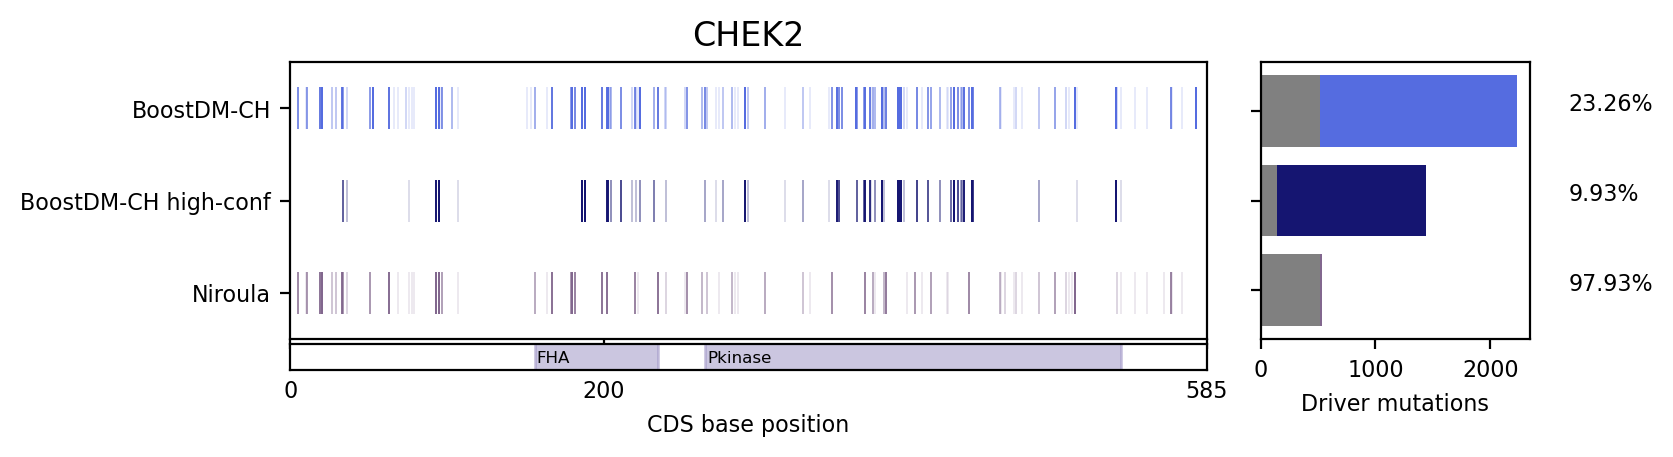

In [11]:
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib
import matplotlib.pyplot as plt

for gene in ['CHEK2']:

    fig = plt.figure(figsize=(8,2), dpi=200)
    # ! SDM change
    # fig.suptitle('SF3B1', y=1.1)
    gs = gridspec.GridSpec(10, 4, figure=fig)
    # Method comparison
    ax0 = plt.subplot(gs[:-1, :3])
    #protein body
    ax1 = plt.subplot(gs[-1, :3], sharex=ax0)
    #Method overlapping
    ax2 = plt.subplot(gs[:-1, 3])

    GENE = boostDM_predictions[(boostDM_predictions['SYMBOL']==gene)]

    # get PFAM domains and subset the mutation data
    PFAM_files = '../../../Paper_data/pfam/pfam_biomart.tsv.gz'
    PFAM_info = '../../../Paper_data/pfam/pfam_names.info.csv'
    subset_data_pfam = get_PFAMs_per_transcript(PFAM_files, PFAM_info, get_transctipt(gene))
    subset_data_pfam


    ######
    #BARPLOT
    ######
    BoostDM_high = len(GENE[(GENE['boostDM_score']>=0.9)]['ID2'].to_list())
    BoostDM = len(GENE[(GENE['Drivers_12genes']==1)]['ID2'].to_list())
    Overlapping_BoostDM = len(GENE[(GENE['Drivers_12genes']==1) & (GENE['Niroula']==1)]['ID2'].to_list())

    Niroula = len(GENE[(GENE['Niroula']==1)]['ID2'].to_list())
    Overlapping_Niroula = len(GENE[(GENE['boostDM_score']>=0.9) & (GENE['Niroula']==1)]['ID2'].to_list())

    # create data
    x = ['Niroula', 'BoostDM_HQ', 'BoostDM']
    y1 = [Overlapping_BoostDM, Overlapping_Niroula, Overlapping_BoostDM]
    y2 = [0, 0, BoostDM-Overlapping_BoostDM]
    y3 = [0, BoostDM_high-Overlapping_Niroula, 0]
    y4 = [Niroula-Overlapping_BoostDM, 0, 0]

    h = 0.6
    size_param = 8

    # plot bars in stack manner
    #     plt.figure(figsize=(4, 2))
    max_len = max([BoostDM,Niroula,BoostDM_high])
    ax2.barh(x, y1, color='grey')
    ax2.barh(x, y2, left=y1, color='#556CE0')
    ax2.barh(x, y3, left=y1, color='#151571')
    ax2.barh(x, y4, left=y1, color='#82678E')

    ax2.text(max_len+(max_len/5), 0, str(round(Overlapping_BoostDM/Niroula*100, 2))+'%', size=size_param)
    ax2.text(max_len+(max_len/5), 1, str(round(Overlapping_Niroula/BoostDM_high*100, 2))+'%', size=size_param)
    ax2.text(max_len+(max_len/5), 2, str(round(Overlapping_BoostDM/BoostDM*100, 2))+'%', size=size_param)

    # plt.text(20, 0, str(round(Inter/Boost*100, 2))+'%')
    ax2.set_yticklabels([])
    ax2.tick_params(axis='x', labelsize=8)
    ax2.set_xlabel('Driver mutations', fontsize = size_param)

    ######
    #Protein domains
    ######
    ax1.set_xlabel('CDS base position',fontsize = size_param)
    ax1.tick_params(axis='x', length=0)
    ax1.set_yticks([])

    ax1.set_ylim(0, 1)
    for i, r in subset_data_pfam.iterrows():
        start_base = r['START']
        size_base = r['SIZE']
        rect = patches.Rectangle(xy=(start_base, 0), width=size_base, height=5, color=r["Color"], alpha=0.5, zorder=2)
        ax1.annotate(text=r["DOMAIN_NAME"], xy=(start_base + 1, 0.3), fontsize=6)
        ax1.add_patch(rect)
    ax1.set_xlim(0, max(GENE['Prot_pos']))
    ax1.set_xticks(np.append(np.arange(0, max(GENE['Prot_pos']), 200)[:-1], max(GENE['Prot_pos'])))
    ax1.set_xticklabels(np.append(np.arange(0, max(GENE['Prot_pos']), 200)[:-1], max(GENE['Prot_pos'])), fontsize = 8)

    ######
    #Method comparison             
    ######
    ax0.set_title(gene)
    ax0.plot(GENE[GENE['Drivers_12genes']==1]['Prot_pos'], np.full_like(GENE[GENE['Drivers_12genes']==1]['Prot_pos'], 4), '|', markeredgewidth=0.1, markersize=15, color='#556CE0')
    ax0.plot(GENE[GENE['boostDM_score']>=0.9]['Prot_pos'], np.full_like(GENE[GENE['boostDM_score']>=0.9]['Prot_pos'], 2), '|k', markeredgewidth=0.1,  markersize=15, color='#151571')
    ax0.plot(GENE[GENE['Niroula']==1]['Prot_pos'], np.full_like(GENE[GENE['Niroula']==1]['Prot_pos'], 0), '|k', markeredgewidth=0.1,  markersize=15, color='#82678E')
    ax0.set_ylim(-1, 5)
    if max(GENE['Prot_pos'])<500:
        ax0.set_xticks(np.append(np.arange(0, max(GENE['Prot_pos']), 50)[:-1], max(GENE['Prot_pos'])))
        ax0.set_xticklabels(np.append(np.arange(0, max(GENE['Prot_pos']), 50)[:-1], max(GENE['Prot_pos'])), fontsize = 0)
    elif max(GENE['Prot_pos'])<1400:
        ax0.set_xticks(np.append(np.arange(0, max(GENE['Prot_pos']), 200)[:-1], max(GENE['Prot_pos'])))
        ax0.set_xticklabels([int(x) for x in np.append(np.arange(0, max(GENE['Prot_pos']), 200)[:-1], max(GENE['Prot_pos'])).tolist()], fontsize = 0)
    elif max(GENE['Prot_pos'])>=1000:
        ax0.set_xticks(np.append(np.arange(0, max(GENE['Prot_pos']), 500)[:-1], max(GENE['Prot_pos'])))
        ax0.set_xticklabels(np.append(np.arange(0, max(GENE['Prot_pos']), 500)[:-1], max(GENE['Prot_pos'])), fontsize = 0)
    ax0.set_yticks([0,2,4])
    ax0.set_yticklabels(['Niroula', 'BoostDM-CH high-conf', 'BoostDM-CH'], fontsize = size_param) 